### Install and import necessary packages

In [1]:
!pip install transformers seqeval[gpu]
!pip install datasets
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 14.2 MB/s 
     |████████████████████████████████| 43 kB 2.6 MB/s 
     |████████████████████████████████| 120 kB 70.3 MB/s 
     |████████████████████████████████| 6.6 MB 81.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16180 sha256=1e8b81850b374478c1465ff526743b17344b858ba1dd17af07949cdb40e07fec
  Stored in directory: /root/.cache/pip/wheels/05/96/ee/7cac4e74f3b19e3158dce26a20a1c86b3533c43ec72a549fd7
Successfully built seqeval
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 13.0 MB/s 
     |████████████████████████████████| 212 kB 96.8 MB/s 
     |████████████████████████████████| 115 kB 76.3 MB/s 
     |████████████████████████████████| 127 kB 95.3 MB/s 
  Attempting uninstall: urllib3
    Found existing ins

In [2]:
import torch
import datasets
from collections import Counter
from datasets import load_dataset
from datasets import Dataset
from transformers import XLNetTokenizer, XLNetForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import TrainingArguments, Trainer
from transformers import EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import pandas as pd

In [3]:
torch.cuda.is_available()
device = torch.device("cuda")

#### Load data

In [4]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
!ls '/content/drive/MyDrive/eth_CIL_exercise/data'
df_train = pd.read_csv('/content/drive/MyDrive/case-2022/data/ST1/train_subtask1.csv')
df_val = pd.read_csv('/content/drive/MyDrive/case-2022/data/ST1/dev_subtask1.csv')
df_test = pd.read_csv('/content/drive/MyDrive/case-2022/data/ST1/test_subtask1_text.csv')
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)


Mounted at /content/drive
clean_test.csv	clean_train.csv  clean_val.csv	logreg_input
(2925, 6)
(323, 6)
(311, 2)


In [5]:
df_trainval = pd.concat([df_train,df_val])
df_test['label'] = 0
df_test['agreement'] = 0
df_test['num_votes'] = 0
print(df_trainval.shape)
print(df_test.shape)

(3248, 6)
(311, 5)


In [6]:
train_ds = Dataset.from_pandas(df_train)
val_ds = Dataset.from_pandas(df_val)
trainval_ds = Dataset.from_pandas(df_trainval)
test_ds = Dataset.from_pandas(df_test)
train_ds[111] # Example of instance of the dataset

{'index': 'train_01_111',
 'text': 'They exhorted us to join the protest against the recommendations of the Mandal Commission , which had been implemented a day earlier .',
 'label': 0,
 'agreement': 0.666666667,
 'num_votes': 3,
 'sample_set': 'train_01'}

#### Preprocessing - Data exploration

In [7]:
df_train['ce'] = df_train['agreement'] # add new column 
df_train['non-ce'] = df_train['agreement']
for i in range(df_train.shape[0]): 
  if df_train['label'][i] == 1:
    df_train['ce'][i] = df_train['agreement'][i] 
    df_train['non-ce'][i] = (1 - df_train['agreement'][i])
  else:
    df_train['non-ce'][i] = df_train['agreement'][i]
    df_train['ce'][i] = (1 - df_train['agreement'][i])
    

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is try

In [8]:
df_train.head(2)

,index,text,label,agreement,num_votes,sample_set,ce,non-ce
0,train_01_0,The State alleged they hacked Sabata Petros Ch...,1,0.666667,3,train_01,0.666667,0.333333
1,train_01_1,Chale was allegedly chased by a group of about...,0,1.000000,3,train_01,0.000000,1.000000


In [9]:
df_train.head(2)

,index,text,label,agreement,num_votes,sample_set,ce,non-ce
0,train_01_0,The State alleged they hacked Sabata Petros Ch...,1,0.666667,3,train_01,0.666667,0.333333
1,train_01_1,Chale was allegedly chased by a group of about...,0,1.000000,3,train_01,0.000000,1.000000


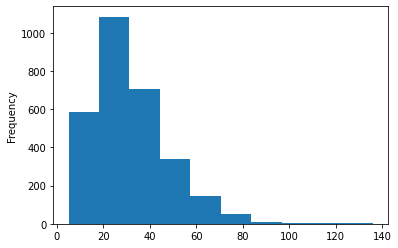

In [10]:
# Get length of each datapoint from the train dataset #remember to do it for all trainset
length = []
for line in train_ds:
  length.append(len(line['text'].split()))
#histogram
df = pd.Series(length)
ax = df.plot.hist()


# Tokenizing data - Model name

**model_name**
- [x] model_name = 'bert-base-cased'


In [11]:
# Load BERT/ROBERTA/XLNet tokenizer.
model_name = 'bert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [12]:
#example: tokenizing one datapoint 
# tokenizer(train_ds[7]['text'])

In [13]:

def encode_dataset(dataset: datasets.arrow_dataset.Dataset) -> list:
  '''
  Transforming each instance of the dataset with the Tokenizer
  '''
  encoded_dataset = []
  for item in dataset:
    # Tokenize the sentence.
    sentence_encoded = tokenizer(item['text'],
                                return_tensors="pt", 
                                padding='max_length', 
                                truncation=True, 
                                max_length=60) 
    
    sentence_encoded['labels'] = torch.LongTensor(np.array([item['label']]))
    sentence_encoded['num_votes'] = torch.LongTensor(np.array(np.around([item['num_votes']],3))) #number of vote
    sentence_encoded['agreement'] = torch.Tensor(np.array([item['agreement']])) #agreement
    encoded_dataset.append(sentence_encoded)

  # Reduce dimensionality of tensors.
  for item in encoded_dataset:
    for key in item:
      item[key] = torch.squeeze(item[key])
  return encoded_dataset

In [14]:
# Tokenizing datasets
encoded_dataset_train = encode_dataset(train_ds)
encoded_dataset_val = encode_dataset(val_ds)
encoded_dataset_trainval = encode_dataset(trainval_ds)
encoded_dataset_test = encode_dataset(test_ds)

# Fine tunning of the model

In [15]:
# Create dictionaries to transform from labels to id and vice-versa.
id2label = {0 : 'causualeffect',
            1 : 'non-causualeffect'}
label2id = {v:k for k,v in id2label.items()}
num_labels = len(label2id)
print(id2label)

{0: 'causualeffect', 1: 'non-causualeffect'}


In [16]:
# Example of dataset
# for token, token_label in zip(tokenizer.convert_ids_to_tokens(encoded_dataset_train[50]["input_ids"]), encoded_dataset_train[50]["input_ids"]):
#   print('{0:10}  {1}'.format(token, token_label))
inputs = encoded_dataset_train[111]

In [17]:
from torch import nn
from transformers import Trainer


class CustomTrainer(Trainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def compute_loss(self, model, inputs, return_outputs=False):
        y_true = inputs.get("labels")
        n = inputs.get('num_votes') #number of votes
        r = inputs.get('agreement') #agreement
        # forward pass 
        inputs2 = {"input_ids":inputs.get("input_ids"), "labels":inputs.get("labels"),
                   "attention_mask":inputs.get("attention_mask"),
                   "token_type_ids":inputs.get("token_type_ids")}
        outputs = model(**inputs2)
        logits = outputs.get("logits")
        y_pred = torch.softmax(logits,dim=1)[:,1]
        # compute custom loss  #todo: 
        loss1 = n*r*torch.log(y_pred) + n*(1-r)*torch.log(1-y_pred) #if y_true = 1
        loss2 = n*r*torch.log(1-y_pred) + n*(1-r)*torch.log(y_pred) #if y_true = 0
        loss = -torch.mean(y_true*loss1+(1-y_true)*loss2)
        return (loss, outputs) if return_outputs else loss
    # def create_optimizer_and_scheduler(self, num_training_steps: int):
          # no_decay = ["bias", "LayerNorm.weight"]
          # # Add any new parameters to optimize for here as a new dict in the list of dicts
          # optimizer_grouped_parameters = ...
        #  self.optimizer = AdamW(#optimizer_grouped_parameters, 
        #                         lr=self.args.learning_rate, 
        #                         eps=self.args.adam_epsilon)
        #  self.lr_scheduler = get_linear_schedule_with_warmup(
        #      self.optimizer, 
        #      num_warmup_steps=self.args.warmup_steps, 
        #      num_training_steps=self.num_training_steps)

In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [19]:
# Common training arguments
training_args = TrainingArguments(
    num_train_epochs=10,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    logging_dir='logs',
    no_cuda=False,  
    output_dir = None #'drive/MyDrive/',
    seed = 82,
    learning_rate = 5e-5, #defaults 1e-3
    warmup_steps=0, # number of warmup steps for learning rate scheduler
    weight_decay=0.01,
    evaluation_strategy='steps' #defaults: 'no'
)

# FINE TUNING PROCESS

# create model
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=num_labels,ignore_mismatched_sizes=True) 

# TODO: create_optimizer -  create_scheduler
from transformers.optimization import Adafactor, AdafactorSchedule
# optimizer = Adafactor(
#     model.parameters(),
#      lr=5e-5,
#     eps=(1e-30, 1e-3), #defaults (1e-30, 1e-3)
#     clip_threshold=1.0,
#     decay_rate=-0.8,
#     beta1=None,
#     weight_decay=0.0,
#     relative_step=False,
#     scale_parameter=True,
#     warmup_init=False,
# )
# lr_scheduler = AdafactorSchedule(optimizer)
from transformers import AdamW, get_linear_schedule_with_warmup
optimizer = AdamW(model.parameters(), lr=5e-5)
# optimizer = AdamW(model.parameters(), #default using schedule = get_linear_schedule_with_warmup
#                   lr = 2e-5, #default is 5e-5
#                   eps = 1e-8 #default is 1e-8. #need to customize for this arg
#                     ) 

# Create trainer
trainer = CustomTrainer(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    #optimizers=(optimizer, lr_scheduler),
    train_dataset=encoded_dataset_train,
    eval_dataset=encoded_dataset_val,
    compute_metrics=compute_metrics,
    )
# Fine tunning
trainer.train()


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

Step,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
500,1.451100,3.073809,0.792570,0.819407,0.787565,0.853933
1000,1.162200,3.163038,0.783282,0.807692,0.790323,0.825843
1500,0.959000,3.437694,0.786378,0.824427,0.753488,0.910112
2000,0.827700,4.130301,0.777090,0.805405,0.776042,0.837079
2500,0.794100,4.203093,0.783282,0.816754,0.764706,0.876404
3000,0.743300,3.929461,0.798762,0.826667,0.786802,0.870787
3500,0.714000,4.271086,0.792570,0.820375,0.784615,0.859551


***** Running Evaluation *****
  Num examples = 323
  Batch size = 8
Saving model checkpoint to drive/MyDrive/checkpoint-500
Configuration saved in drive/MyDrive/checkpoint-500/config.json
Model weights saved in drive/MyDrive/checkpoint-500/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/checkpoint-500/tokenizer_config.json
Special tokens file saved in drive/MyDrive/checkpoint-500/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 323
  Batch size = 8
Saving model checkpoint to drive/MyDrive/checkpoint-1000
Configuration saved in drive/MyDrive/checkpoint-1000/config.json
Model weights saved in drive/MyDrive/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in drive/MyDrive/checkpoint-1000/tokenizer_config.json
Special tokens file saved in drive/MyDrive/checkpoint-1000/special_tokens_map.json
***** Running Evaluation *****
  Num examples = 323
  Batch size = 8
Saving model checkpoint to drive/MyDrive/checkpoint-1500
Configuration saved in 

TrainOutput(global_step=3660, training_loss=0.9378772944049105, metrics={'train_runtime': 492.257, 'train_samples_per_second': 59.42, 'train_steps_per_second': 7.435, 'total_flos': 901874808900000.0, 'train_loss': 0.9378772944049105, 'epoch': 10.0})

In [20]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 323
  Batch size = 8


{'eval_loss': 4.225794315338135,
 'eval_accuracy': 0.8018575851393189,
 'eval_f1': 0.8260869565217391,
 'eval_precision': 0.8,
 'eval_recall': 0.8539325842696629,
 'eval_runtime': 1.2172,
 'eval_samples_per_second': 265.368,
 'eval_steps_per_second': 33.685,
 'epoch': 10.0}

# Model evaluation

### Devset

In [21]:
# Get the predicted labels
preds_val = trainer.predict(encoded_dataset_val)
predictions = preds_val.predictions.argmax(-1)

# Create array with predicted labels and expected.
true_values = np.array(preds_val.label_ids).flatten()
predicted_values = np.array(preds_val.predictions.argmax(-1)).flatten()

# Filter the labels. We only produce a label for each word. We filter labels
# of subwords and special tokens, such as PAD
proc_predicted_values = [prediction for prediction, label in zip(predicted_values, true_values) if label != -100]
proc_true_values = [label for prediction, label in zip(predicted_values, true_values) if label != -100]

# Evaluate models
model_performance = {}
model_performance['accuracy'] = accuracy_score(proc_true_values, proc_predicted_values)
model_performance['precision_micro'] = precision_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['precision_macro'] = precision_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['recall_micro'] = recall_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['recall_macro'] = recall_score(proc_true_values, proc_predicted_values, average='macro')
model_performance['f1_micro'] = f1_score(proc_true_values, proc_predicted_values, average='micro')
model_performance['f1_macro'] = f1_score(proc_true_values, proc_predicted_values, average='macro')

model_performance['confusion_matrix'] = confusion_matrix(proc_true_values, proc_predicted_values)
model_performance['confusion_matrix_normalized'] = confusion_matrix(proc_true_values, proc_predicted_values, normalize='true')
# print('------------Model performance------------')
# print(f'  recall_micro: {model_performance["recall_micro"]}')
# print(f'  recall_macro: {model_performance["recall_macro"]}')
# print(f'  accuracy: {model_performance["accuracy"]}')
print(f'  precision_micro: {model_performance["precision_micro"]}')
print(f'  precision_macro: {model_performance["precision_macro"]}')
print(f'  f1-micro: {model_performance["f1_micro"]}')
print(f'  f1-macro: {model_performance["f1_macro"]}')

***** Running Prediction *****
  Num examples = 323
  Batch size = 8


  precision_micro: 0.8018575851393189
  precision_macro: 0.8022556390977444
  f1-micro: 0.8018575851393189
  f1-macro: 0.7979355645918048


To understand better the performance of the classifier, we display the confusion matrix:

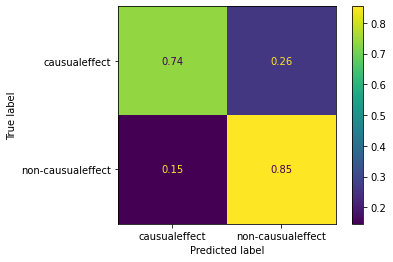

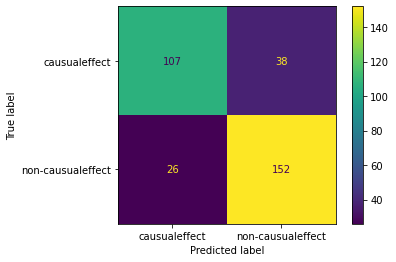

In [22]:
disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix_normalized'],display_labels = list(id2label.values()))
disp.plot()

disp = ConfusionMatrixDisplay(confusion_matrix=model_performance['confusion_matrix'],display_labels = list(id2label.values()))
disp.plot()

### Predictions

In [47]:
# # Common training arguments
# training_args = TrainingArguments(
#     num_train_epochs=10,
#     per_device_train_batch_size=8,
#     per_device_eval_batch_size=8,
#     logging_dir='logs',
#     no_cuda=False,  
#     output_dir = 'drive/MyDrive/',
#     seed = 82,
#     learning_rate = 5e-5, #defaults 1e-3
#     warmup_steps=0, # number of warmup steps for learning rate scheduler
#     weight_decay=0.01,
#     evaluation_strategy='no' #set no for testing phase
# )

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [46]:
# trainer_pred = CustomTrainer(
#     model=model,
#     tokenizer=tokenizer,
#     args=training_args,
#     #optimizers=(optimizer, lr_scheduler),
#     train_dataset=encoded_dataset_trainval,
#     #compute_metrics=compute_metrics,
#     )
# # Fine tunning
# trainer_pred.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3248
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 406


Step,Training Loss




Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=406, training_loss=0.8253615806842672, metrics={'train_runtime': 48.8571, 'train_samples_per_second': 66.48, 'train_steps_per_second': 8.31, 'total_flos': 100146645446400.0, 'train_loss': 0.8253615806842672, 'epoch': 1.0})

In [112]:
preds = trainer.predict(encoded_dataset_test)
predictions = preds.predictions.argmax(-1)
predicted_values = np.array(preds.predictions.argmax(-1)).flatten()

***** Running Prediction *****
  Num examples = 311
  Batch size = 8


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


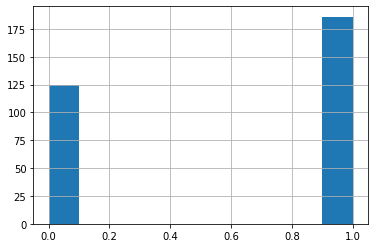

In [105]:
df_preds_label = pd.DataFrame(predicted_values)
df_preds_label = df_preds_label.reset_index()
df_preds_label.columns = ['index','prediction']
df_preds_label['prediction'].hist()

In [125]:
import json
# Save the DataFrame to a file on the Colab backend.
with open('submission.json', 'w') as f:
    f.write('\n'.join(json.dumps(i) for i in df_preds_label.to_dict(orient='records')))

In [127]:
# !cat submission.json

In [128]:
from google.colab import files
files.download('submission.json')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [39]:
# preds_logit = pd.DataFrame(preds[0]) #predicted logits
# preds_logit.head(2)

,0,1
0,-3.166792,2.841280
1,-2.922536,2.526386
